In [1]:
!nvidia-smi

Tue Mar 23 02:13:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   36C    P0    37W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

https://www.kaggle.com/cdeotte/part-2-rapids-tfidfvectorizer-cv-0-700

In [2]:
%load_ext autoreload
%autoreload 2
%aimport

HOME = '/data/git/shopee-product-matching'
import sys
sys.path.append(f"{HOME}/src")

p_in = f'{HOME}/input'
p_comp = f'{p_in}/shopee-product-matching'

# p_out = f'{HOME}/output/dev0019'
# !mkdir -p {p_out}

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
pout = f"{HOME}/data/dev0019"
!mkdir -p $pout

In [4]:
from cuml.neighbors import NearestNeighbors

# vision

In [19]:
feats = np.load(f"{HOME}/output/dev0005/vfeats.npy")
feats.shape

(34250, 1280)

In [13]:
N_NBRS = 50

In [4]:
nnmdl = NearestNeighbors(N_NBRS)
nnmdl.fit(feats)

NearestNeighbors(n_neighbors=50, verbose=4, handle=<cuml.raft.common.handle.Handle object at 0x7f7c59ff3f30>, algorithm='brute', metric='euclidean', p=2, algo_params=None, metric_params=None, output_type='input')

In [14]:
def mk_nnmdl(feats, n_nbrs=N_NBRS):
    nnmdl = NearestNeighbors(N_NBRS)
    nnmdl.fit(feats)
    return nnmdl

In [6]:
nnmdl = mk_nnmdl(feats)

In [7]:
dists, idx = nnmdl.kneighbors(feats[:10])

dists.shape, idx.shape

((10, 50), (10, 50))

In [8]:
idx.dtype

dtype('int64')

In [9]:
(dists<6)[:2]

array([[ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [ True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]])

In [16]:
CHUNK = 1024*4

In [17]:
def get_nbrs(feats, nnmdl, sz_chunk=CHUNK):
    n = len(feats)
    n_nbrs = nnmdl.n_neighbors
    dists = np.zeros((n, n_nbrs), dtype='float')
    idx   = np.zeros((n, n_nbrs), dtype='int')
    n_chunks = len(feats)//sz_chunk
    if len(feats)%sz_chunk!=0: n_chunks += 1
    for j in range(n_chunks):
        a = j*sz_chunk
        b = (j+1)*sz_chunk
        b = min(b,len(feats))
        print('chunk', a,'to',b)
        dists_, idx_ = nnmdl.kneighbors(feats[a:b,])
        dists[a:b] = dists_
        idx[a:b] = idx_
        
    return dists, idx

In [11]:
dists, idx = get_nbrs(feats, nnmdl)

chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


In [17]:
dists.shape, idx.shape

((34250, 50), (34250, 50))

In [22]:
np.save(f"{pout}/dists_v.npy", dists)
np.save(f"{pout}/idx_v.npy", idx)

## threshold

In [30]:
dists = np.load(f"{pout}/dists_v.npy")
idx = np.load(f"{pout}/idx_v.npy")

In [5]:
df = pd.read_csv(f'{p_comp}/train.csv')
pids = df.posting_id.values

grp2ids = df.groupby('label_group').posting_id.agg('unique').to_dict()
targets = df.label_group.map(grp2ids)

def getf1(x,y):
    n = len(np.intersect1d(x,y))
    return 2*n / (len(x)+len(y))

def getf1s(xs,ys):
    return (getf1(x,y) for x,y in zip(xs,ys))

def meanf1(xs,ys):
    return np.mean(list(getf1s(xs, ys)))

def get_preds_by_thrsh(dists, idx, thrsh):
    preds_idx = (ind[dst<thrsh] for dst,ind in zip(dists, idx))
    return [pids[o] for o in preds_idx]

In [32]:
preds = get_preds_by_thrsh(dists, idx, thrsh=6.)
meanf1(preds,targets)

0.6432038327115934

In [33]:
thrshes = np.linspace(6.5,7.5,num=21)
thrshes

array([6.5 , 6.55, 6.6 , 6.65, 6.7 , 6.75, 6.8 , 6.85, 6.9 , 6.95, 7.  ,
       7.05, 7.1 , 7.15, 7.2 , 7.25, 7.3 , 7.35, 7.4 , 7.45, 7.5 ])

100%|██████████| 21/21 [00:21<00:00,  1.03s/it]


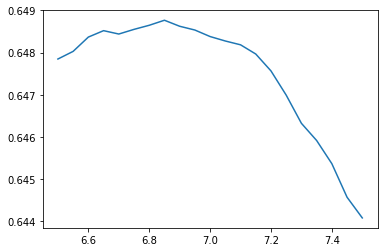

In [34]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(dists, idx, thrsh)
    f1_lst.append(meanf1(preds,targets))
plt.plot(thrshes, f1_lst)  

In [6]:
def find_best(dists, idx, thrshes):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(dists, idx, thrsh)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    return f1_best, thrsh_best, preds_best

In [36]:
f1_best, thrsh_best, preds_best = find_best(dists, idx, thrshes)
f1_best, thrsh_best

100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


(0.64876765208333, 6.85)

# text

In [23]:
feats = np.load(f"{HOME}/output/dev0005/tfeats.npy")
feats.shape

(34250, 768)

In [25]:
nnmdl = mk_nnmdl(feats)

In [26]:

dists, idx = get_nbrs(feats, nnmdl)



chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


In [27]:
dists.shape, idx.shape

((34250, 50), (34250, 50))

In [29]:
np.save(f"{pout}/dists_t.npy", dists)
np.save(f"{pout}/idx_t.npy", idx)

## threshold

In [37]:
dists = np.load(f"{pout}/dists_t.npy")
idx = np.load(f"{pout}/idx_t.npy")

In [38]:
preds = get_preds_by_thrsh(dists, idx, thrsh=6.)
meanf1(preds,targets)

0.5674315209884165

In [39]:
thrshes = np.linspace(5.5,6.5,num=11)
thrshes

array([5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5])

100%|██████████| 11/11 [00:11<00:00,  1.02s/it]


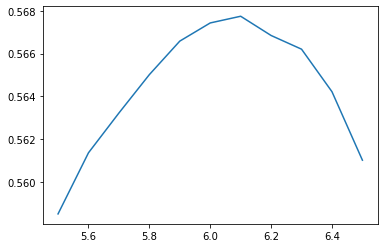

In [40]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(dists, idx, thrsh)
    f1_lst.append(meanf1(preds,targets))
plt.plot(thrshes, f1_lst)  

In [41]:
f1_best, thrsh_best, preds_best = find_best(dists, idx, thrshes)
f1_best, thrsh_best

100%|██████████| 11/11 [00:11<00:00,  1.01s/it]


(0.5677441988960824, 6.1)

# hash

In [ ]:
hfeats = df.image_phash.apply(lambda x: bin(int(x, 16))).values

In [8]:
%%time
hfeats = np.array([[eval(o) for o in x[2:]] for x in hfeats], dtype=np.bool)

CPU times: user 8.2 s, sys: 3.87 ms, total: 8.21 s
Wall time: 8.2 s


In [18]:
nnmdl = mk_nnmdl(feats)

In [19]:
dists, idx = get_nbrs(feats, nnmdl)

chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


In [27]:
dists.shape, idx.shape

((34250, 50), (34250, 50))

In [20]:
np.save(f"{pout}/dists_h.npy", dists)
np.save(f"{pout}/idx_h.npy", idx)

## threshold

In [7]:
dists = np.load(f"{pout}/dists_h.npy")
idx = np.load(f"{pout}/idx_h.npy")

In [13]:
preds = get_preds_by_thrsh(dists, idx, thrsh=3.)
meanf1(preds,targets)

0.5956242937941346

In [21]:
thrshes = np.linspace(2.5,3.5,num=11)
thrshes

array([2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5])

100%|██████████| 11/11 [00:11<00:00,  1.06s/it]


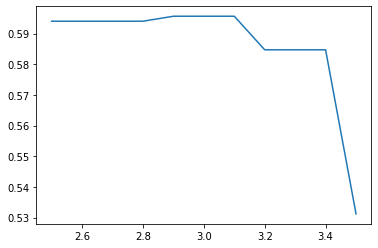

In [22]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(dists, idx, thrsh)
    f1_lst.append(meanf1(preds,targets))
plt.plot(thrshes, f1_lst)  

In [23]:
f1_best, thrsh_best, preds_best = find_best(dists, idx, thrshes)
f1_best, thrsh_best

100%|██████████| 11/11 [00:11<00:00,  1.07s/it]


(0.5956242937941346, 3.1)

# fin

In [42]:
!nvidia-smi

Tue Mar 23 02:08:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  